<a href="https://colab.research.google.com/github/ArtemBurenok/genetic_algorithms/blob/main/genetic_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap

In [ ]:
import numpy as np
from deap import tools
from deap import algorithms

In [ ]:
# алгоритм с эллитизмом
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Оценить хромосомы с маленькой пригодностью
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # начало процесса генерации
    for gen in range(1, ngen + 1):

        # выбрать хромосомы для следующего поколения
        offspring = toolbox.select(population, len(population) - hof_size)

        # скрещивание, мутации
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # оценить хромосомы с маленькой пригодностью
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # добавить лучшших в популяцию
        offspring.extend(halloffame.items)
        # обновить список эллитизма
        halloffame.update(offspring)
        # заменить текущую популяцию новой
        population[:] = offspring

        # добавить статистику поколения в общую статистику
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [ ]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DIMENSIONS = 2  # количество переменных
BOUND_LOW, BOUND_UP = -512.0, 512.0  # границы для всех переменных

POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # вероятность кроссовера
P_MUTATION = 0.1   # вероятность мутации
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30 # количество переменных, которые будут учавствовать в элитизме
CROWDING_FACTOR = 20.0  # скученность для кроссовера и мутации

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [ ]:
# вспомогательная функция для создания случайных действительных чисел, равномерно распределенных в заданном диапазоне
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

In [ ]:
# функция Растригина
def rastrigin(x):
    return (10 * len(x) + np.sum([xi ** 2 - 10 * np.cos(2 * np.pi * xi) for xi in x])),

In [ ]:
def main_process(POPULATION_SIZE, P_CROSSOVER, P_MUTATION, MAX_GENERATIONS, HALL_OF_FAME_SIZE, CROWDING_FACTOR):
    toolbox = base.Toolbox()

    # определить стратегию:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

    # создаём хромосомы
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # оператор, который случайным образом возвращает число с плавающей запятой в нужном диапазоне и размере
    toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

    # отдельный оператор для заполнения индивидуального экземпляра:
    toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

    # оператор для создания популяции
    toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

    # оператор функции, которую необходимо оптимизировать
    toolbox.register("evaluate", rastrigin)

    # операторы выбора, скрещивания, мутации
    toolbox.register("select", tools.selTournament, tournsize=2)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

    # создание первоначальной популяции
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # статистика для каждой эпохи
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # определяем
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # генетический алгоритм с элитизмом
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # информация для лучшего решения
    best = hof.items[0]
    print("-- Лучшая хромосома = ", best)
    print("-- Лучшая функция приспособленности = ", best.fitness.values[0])

    # статистика (nevals - количество хромосом в последнем поколении)
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    plt.show()


gen	nevals	min 	avg   
0  	300   	1817	179147
1  	245   	53.8496	102511
2  	249   	53.8496	50636.2
3  	245   	53.8496	24940.3
4  	251   	27.8528	10822.2
5  	244   	27.8528	5369.08
6  	253   	27.8528	2878.49
7  	248   	7.97805	1494.43
8  	257   	7.97805	865.265
9  	250   	7.97805	498.932
10 	253   	6.06373	705.421
11 	248   	4.66481	401.877
12 	239   	2.35703	243.744
13 	257   	1.53204	335.391
14 	247   	1.03728	222.207
15 	242   	1.03728	384.439
16 	242   	1.03728	273.282
17 	262   	1.01982	190.848
18 	250   	1.00596	201.909
19 	242   	1.00596	495.79 
20 	242   	1.00284	301.61 
21 	246   	1.00284	127.71 
22 	251   	0.996489	353.881
23 	256   	0.99607 	246.062
24 	239   	0.995776	503.768
25 	247   	0.995776	540.155
26 	246   	0.995733	415.849
27 	251   	0.995521	382.718
28 	251   	0.995521	205.69 
29 	245   	0.995376	329.902
30 	251   	0.995373	577.832
31 	250   	0.995348	651.35 
32 	241   	0.995348	255.722
33 	243   	0.995345	310.965
34 	252   	0.995343	320.067
35 	244   	0.995342	268.

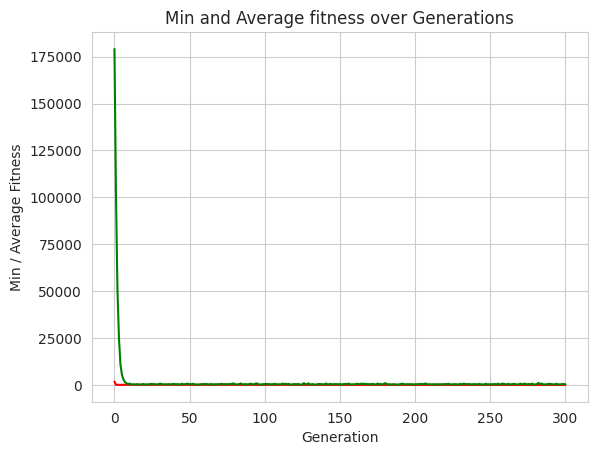

In [ ]:
main_process(POPULATION_SIZE, P_CROSSOVER, P_MUTATION, MAX_GENERATIONS, HALL_OF_FAME_SIZE, CROWDING_FACTOR)

## Изменены вероятность кроссовера и мутации

In [ ]:
DIMENSIONS = 2  # количество переменных
BOUND_LOW, BOUND_UP = -512.0, 512.0  # границы для всех переменных

POPULATION_SIZE = 300
P_CROSSOVER = 0.5  # вероятность кроссовера
P_MUTATION = 0.5   # вероятность мутации
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30 # количество переменных, которые будут учавствовать в элитизме
CROWDING_FACTOR = 20.0  # скученность для кроссовера и мутации

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

gen	nevals	min    	avg   
0  	300   	4570.84	186038
1  	193   	2850.38	112421
2  	197   	322.911	60012 
3  	208   	189.318	28961.2
4  	205   	15.2566	13215.1
5  	209   	15.2566	8043.67
6  	212   	15.2566	5012.52
7  	204   	15.2566	4429.53
8  	204   	15.2566	3226.17
9  	194   	15.2566	2674.31
10 	203   	11.7514	2357.44
11 	215   	7.69434	2432.46
12 	170   	7.69434	2708.14
13 	192   	2.12845	2002.87
14 	201   	2.12845	2183.77
15 	214   	2.12845	1884.74
16 	210   	2.12845	2142.85
17 	210   	2.12845	2530.85
18 	197   	1.36642	1970.33
19 	219   	1.36642	1728.17
20 	204   	1.10188	2870.67
21 	209   	1.10188	2365.5 
22 	218   	1.10188	1807.11
23 	196   	1.10188	2134.84
24 	186   	1.05428	2028.57
25 	215   	1.05197	2120.16
26 	195   	1.05197	2313.37
27 	201   	1.04714	1871.2 
28 	205   	1.03081	2543.65
29 	197   	0.839956	2256.06
30 	206   	0.839956	1929.78
31 	204   	0.839956	2365.54
32 	192   	0.131496	2012.99
33 	215   	0.131496	1756.64
34 	204   	0.131496	2492.52
35 	200   	0.131496	2037.4

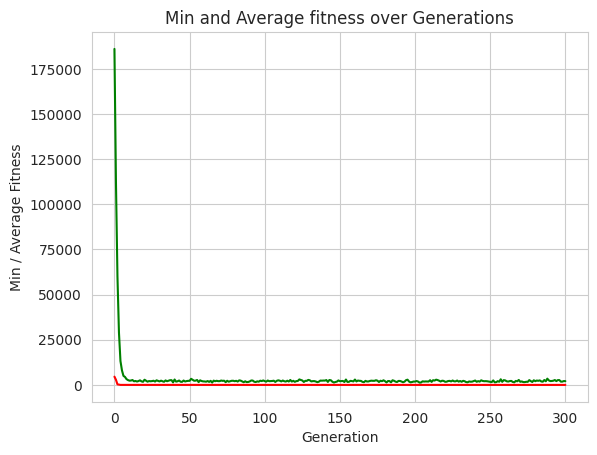

In [ ]:
main_process(POPULATION_SIZE, P_CROSSOVER, P_MUTATION, MAX_GENERATIONS, HALL_OF_FAME_SIZE, CROWDING_FACTOR)

## Измененр количество хромосом в списке эллитизма

In [ ]:
DIMENSIONS = 2  # количество переменных
BOUND_LOW, BOUND_UP = -512.0, 512.0  # границы для всех переменных

POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # вероятность кроссовера
P_MUTATION = 0.1   # вероятность мутации
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 100 # количество переменных, которые будут учавствовать в элитизме
CROWDING_FACTOR = 20.0  # скученность для кроссовера и мутации

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

gen	nevals	min 	avg   
0  	300   	1817	179147
1  	185   	1073.01	95246 
2  	174   	1073.01	50206.1
3  	185   	667.896	26324.9
4  	185   	667.896	13036.2
5  	184   	128.997	6961.13
6  	183   	128.997	3661.24
7  	182   	64.4681	2241.41
8  	179   	31.0456	1846.52
9  	183   	9.47935	1447.07
10 	184   	9.47935	1018.31
11 	184   	9.47935	493.651
12 	187   	6.27162	465.528
13 	189   	6.27162	281.585
14 	184   	5.61273	224.352
15 	172   	5.61273	392.129
16 	176   	1.52148	115.883
17 	168   	1.10814	172.161
18 	182   	1.09122	496.999
19 	177   	1.09122	442.64 
20 	177   	1.09122	265.411
21 	173   	1.09122	327.987
22 	187   	1.07107	244.409
23 	188   	1.04769	324.116
24 	179   	1.04769	173.618
25 	183   	0.997226	383.696
26 	183   	0.997226	365.829
27 	192   	0.996249	193.467
28 	178   	0.996249	398.496
29 	188   	0.996249	288.112
30 	179   	0.996227	332.044
31 	190   	0.996227	146.27 
32 	189   	0.995946	417.237
33 	188   	0.995592	364.726
34 	190   	0.995592	416.725
35 	187   	0.995592	349.733

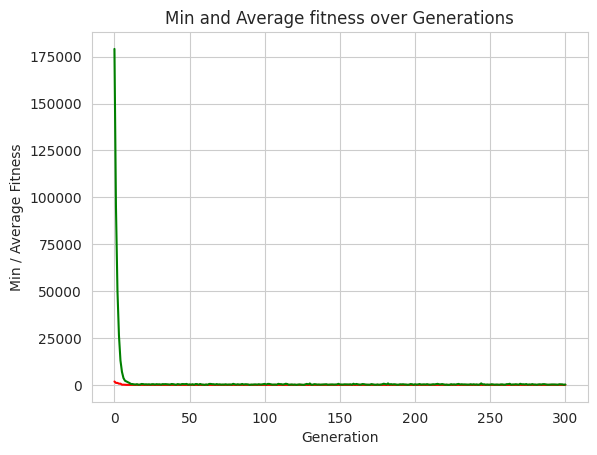

In [ ]:
main_process(POPULATION_SIZE, P_CROSSOVER, P_MUTATION, MAX_GENERATIONS, HALL_OF_FAME_SIZE, CROWDING_FACTOR)